# Training

In [ ]:
import numpy as np
import cv2
import random
from random import randint
from scipy import ndimage
import os
import sys

from google.colab.patches import cv2_imshow

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Model
from keras import metrics
import keras.backend as backend

from sklearn.metrics import accuracy_score

In [ ]:
!mkdir /content/images
!mkdir /content/images/train
!mkdir /content/labels
!mkdir /content/labels/train
!mkdir /content/rotations
!mkdir /content/rotations/train

In [ ]:
# Here are classes named for training
#Dict = {2: 'block'}
Dict = {0: 'advance_to_contact', 1: 'attack', 2: 'block', 3: 'counterattack', 4: 'cover',
        5: 'delay', 6: 'destroy', 7: 'disrupt', 8: 'guard', 9: 'occupy', 
        10: 'retain', 11: 'screen', 12: 'secure', 13: 'seize', 14: 'support_by_fire'}

In [ ]:
Dict_images = {key: [] for key in Dict.values()}
Dict_rotations = {key: [] for key in Dict.values()}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/NATO/train.zip' -d '/content/images/train'
!unzip '/content/drive/My Drive/NATO/train_l.zip' -d '/content/labels/train'
!unzip '/content/drive/My Drive/NATO/train_r.zip' -d '/content/rotations/train'

Streaming output truncated to the last 5000 lines.
  inflating: /content/rotations/train/img45014.txt  
  inflating: /content/rotations/train/img45015.txt  
  inflating: /content/rotations/train/img45016.txt  
  inflating: /content/rotations/train/img45017.txt  
  inflating: /content/rotations/train/img45018.txt  
  inflating: /content/rotations/train/img45019.txt  
  inflating: /content/rotations/train/img45020.txt  
  inflating: /content/rotations/train/img45021.txt  
  inflating: /content/rotations/train/img45022.txt  
  inflating: /content/rotations/train/img45023.txt  
  inflating: /content/rotations/train/img45024.txt  
  inflating: /content/rotations/train/img45025.txt  
  inflating: /content/rotations/train/img45026.txt  
  inflating: /content/rotations/train/img45027.txt  
  inflating: /content/rotations/train/img45028.txt  
  inflating: /content/rotations/train/img45029.txt  
  inflating: /content/rotations/train/img45030.txt  
  inflating: /content/rotations/train/img45031.t

In [ ]:
images = '/content/images/train'
labels = '/content/labels/train'
rotations = '/content/rotations/train'

file_list = os.listdir(images)

for name in file_list:
    tmp_list_class = []
    image = cv2.imread(images+"/"+name, cv2.IMREAD_GRAYSCALE)
    with open(labels+"/"+str(name).split(".")[0]+".txt") as f:
        lines = [line.rstrip('\n') for line in f]
        for line in lines:
            x = int((float(line.split(" ")[1])-(float(line.split(" ")[3])/2)) * 770)
            y = int((float(line.split(" ")[2])-(float(line.split(" ")[4])/2)) * 576)
            w = int(float(line.split(" ")[3]) * 770 + 5)
            h = int(float(line.split(" ")[4]) * 576 + 5)

            crop_image = image[y:y+h, x:x+w]
            tmp_list_class.append(int(line.split(" ")[0]))
            dim = (75, 75)
            resized_img = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA) 
            Dict_images[Dict[int(line.split(" ")[0])]].append(resized_img)
    with open(rotations+"/"+str(name).split(".")[0]+".txt") as a:
        r = [line.rstrip('\n') for line in a]
        i = 0
        for rotation in r:
            Dict_rotations[Dict[tmp_list_class[i]]].append(rotation)
            i += 1


advance_to_contact


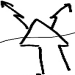

attack


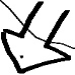

block


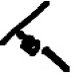

counterattack


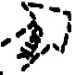

cover


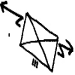

delay


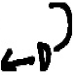

destroy


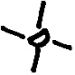

disrupt


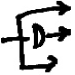

guard


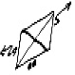

occupy


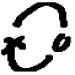

retain


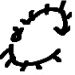

screen


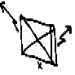

secure


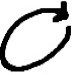

seize


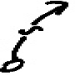

support_by_fire


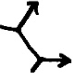

In [ ]:
for i in Dict_images.keys():
    print(str(i))
    cv2_imshow(Dict_images[str(i)][0])

In [ ]:
def angle_error_metric(y_true, y_pred):
    diff = 180 - abs(abs(backend.argmax(y_true) - backend.argmax(y_pred)) - 180)
    return backend.mean(backend.cast(backend.abs(diff), backend.floatx()))

def angle_error(y_true, y_pred):
    diff = 180 - abs(abs(y_true - y_pred) - 180)
    return np.abs(diff)

In [ ]:
for i in Dict_images.keys():
    print(str(i))
    x = Dict_images[str(i)]
    y = Dict_rotations[str(i)]

    y_categorical = to_categorical(y, 360)

    x_train = np.array(x[0:])
    y_train = np.array(y_categorical)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

    print(x_train.shape, y_train.shape)

    # number of classes
    classes = 360

    # model
    #input = Input(shape=(75, 75, 1))
    #x = Conv2D(64, 3, 3, activation='relu')(input)
    #x = Dense(256, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Conv2D(64, 3, 3, activation='relu')(x)
    #x = Dense(128, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Flatten()(x)
    #x = Dense(classes, activation='softmax')(x)

    input = Input(shape=(75, 75, 1))
    x = Conv2D(64, 3, 3, padding = 'same', activation='relu')(input)
    x = Conv2D(64, 3, 3, padding = 'same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, 3, padding = 'same', activation='relu')(x)
    x = Conv2D(64, 3, 3, padding = 'same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding = 'same')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[metrics.categorical_accuracy, angle_error_metric])

    # Fit the model
    model.fit(x_train, y_train, batch_size = 64, epochs = 500)

    model.save(str(i)+"_rotation_model_500e.h5")

Streaming output truncated to the last 5000 lines.
235/235 [==============================] - 1s 6ms/step - loss: 4.9515 - categorical_accuracy: 0.0235 - angle_error_metric: 48.9916
Epoch 6/500
235/235 [==============================] - 1s 6ms/step - loss: 4.5290 - categorical_accuracy: 0.0315 - angle_error_metric: 31.7477
Epoch 7/500
235/235 [==============================] - 1s 6ms/step - loss: 4.2469 - categorical_accuracy: 0.0335 - angle_error_metric: 23.0958
Epoch 8/500
235/235 [==============================] - 1s 6ms/step - loss: 4.0787 - categorical_accuracy: 0.0400 - angle_error_metric: 18.4169
Epoch 9/500
235/235 [==============================] - 1s 6ms/step - loss: 3.9734 - categorical_accuracy: 0.0417 - angle_error_metric: 15.8708
Epoch 10/500
235/235 [==============================] - 1s 6ms/step - loss: 3.8770 - categorical_accuracy: 0.0478 - angle_error_metric: 13.6378
Epoch 11/500
235/235 [==============================] - 1s 6ms/step - loss: 3.8278 - categorical_accur

In [ ]:
import shutil

for i in Dict_images.keys():
    colab_link = '/content/'+str(i)+'_rotation_model_500e.h5'
    gdrive_link = "/content/drive/My Drive/models_rotation/"
    shutil.copy(colab_link, gdrive_link)

# Prediction

In [ ]:
def augment(img, apply_rotation=True, padding_val=255, apply_resize=True, resize_str=20, erosion_dilation=True, add_noise=False, noise_threshold=0.995, scale_to_binary=True, normalize=False):
    # Add rotation 0 to 359 degrees.
    if apply_rotation:
        rotation_angle = np.random.randint(360)
        img = ndimage.rotate(img, rotation_angle, mode='constant', cval=padding_val)

    # Resize the image
    if apply_resize:
        new_sz=(randint((img.shape[1]-resize_str),(img.shape[1]+resize_str)),randint((img.shape[0]-resize_str),(img.shape[0]+resize_str)))
        img = cv2.resize(img, tuple(new_sz))

    # Add either eorison or dilation or neither
    if erosion_dilation:
        kernel = np.ones((3, 3), np.uint8)
        choice = randint(0, 1)
        # print('choice:', choice)
        if choice == 1:
            erode_strenght = randint(1, 2)
            # print('erode_strenght:', erode_strenght)
            img = cv2.erode(img, kernel, iterations = erode_strenght)
        if choice == 2:
            img = cv2.dilate(img, kernel, iterations = 1)
    
    #Apply noise by changing random pixels to one.
    if add_noise:
        img[np.random.rand(img.shape[0], img.shape[1]) > noise_threshold] = 0
    
    #Changes all the pixels with drawing to one and all the "empty" pixels to 0.
    if scale_to_binary:
        thresh, blackwhiteimage = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
    
    # Normalize: 0 to 1
    if normalize:
        blackwhiteimage = blackwhiteimage / 255

    dim = (75, 75)
    resized_img = cv2.resize(blackwhiteimage, dim, interpolation = cv2.INTER_AREA)
    
    return resized_img, rotation_angle


In [ ]:
#model.load_weights('/content/block_symbol_rotation_model_2.h5')

imgs_test = []
data = '/content/test_block'
file_list=os.listdir(data)
print(file_list)

for name in file_list:
    img = cv2.imread(data+"/"+name, cv2.IMREAD_GRAYSCALE)
    imgs_test.append(img)

imgs_test = imgs_test[1:]

x_test = []
y_test = []

dataset_size = 500

for i in range(dataset_size):
    image = random.choice(imgs_test)
    augmented_image, rotation = augment(image)
    x_test.append(augmented_image)
    y_test.append(rotation)

y_pred = []
angle_errors = []

for i, img in enumerate(x_test):
    rotated_img_new = img[None, ]
    predicted_rotation = model.predict(rotated_img_new)
    y_pred.append(np.argmax(predicted_rotation))
    angle_errors.append(angle_error(y_test[i], y_pred[i]))

['block2.png', 'block3.png', 'block1.png', 'block4.png', 'block5.png']
1/1 [==============================] - 0s 16ms/step


In [ ]:
print(len(angle_errors), np.mean(angle_errors))

500 73.832


In [ ]:
kokku = sum(i <= 30 for i in angle_errors)
print(kokku, str(round(kokku/len(angle_errors)*100, 2))+"%")

187 37.4%


In [ ]:
res = tuple(zip(angle_errors, y_test, y_pred))
sorted(res, key = lambda x: (-x[0],x[1],x[2]))

[(180, 176, 356),
 (180, 176, 356),
 (180, 216, 36),
 (179, 92, 273),
 (179, 154, 335),
 (179, 319, 140),
 (179, 319, 140),
 (178, 32, 210),
 (178, 32, 210),
 (178, 73, 251),
 (178, 91, 273),
 (178, 144, 326),
 (178, 178, 356),
 (178, 220, 38),
 (178, 317, 135),
 (178, 317, 135),
 (178, 321, 139),
 (177, 179, 356),
 (177, 179, 356),
 (177, 324, 141),
 (176, 142, 326),
 (176, 154, 330),
 (176, 222, 38),
 (176, 323, 139),
 (175, 208, 33),
 (175, 300, 125),
 (175, 315, 140),
 (174, 41, 215),
 (174, 113, 299),
 (174, 152, 326),
 (174, 182, 356),
 (174, 223, 49),
 (172, 142, 330),
 (172, 184, 356),
 (171, 296, 125),
 (171, 318, 147),
 (170, 94, 264),
 (170, 227, 57),
 (170, 276, 106),
 (169, 317, 148),
 (167, 242, 49),
 (166, 243, 49),
 (166, 318, 152),
 (165, 131, 326),
 (165, 161, 326),
 (165, 334, 139),
 (165, 335, 140),
 (164, 137, 301),
 (163, 138, 301),
 (162, 323, 125),
 (161, 237, 38),
 (159, 85, 244),
 (159, 146, 305),
 (159, 298, 139),
 (159, 299, 140),
 (158, 147, 305),
 (157, 16

## Prediction 2

In [ ]:
!mkdir /content/images
!mkdir /content/images/test
!mkdir /content/labels
!mkdir /content/labels/test
!mkdir /content/rotations
!mkdir /content/rotations/test

mkdir: cannot create directory ‘/content/images’: File exists
mkdir: cannot create directory ‘/content/labels’: File exists
mkdir: cannot create directory ‘/content/rotations’: File exists


In [ ]:
!unzip '/content/drive/My Drive/NATO/test.zip' -d '/content/images/test'
!unzip '/content/drive/My Drive/NATO/test_l.zip' -d '/content/labels/test'
!unzip '/content/drive/My Drive/NATO/test_r.zip' -d '/content/rotations/test'

Archive:  /content/drive/My Drive/NATO/test.zip
  inflating: /content/images/test/img1488.jpg  
  inflating: /content/images/test/img1487.jpg  
  inflating: /content/images/test/img1486.jpg  
  inflating: /content/images/test/img1485.jpg  
  inflating: /content/images/test/img1484.jpg  
  inflating: /content/images/test/img1483.jpg  
  inflating: /content/images/test/img1482.jpg  
  inflating: /content/images/test/img1481.jpg  
  inflating: /content/images/test/img1480.jpg  
  inflating: /content/images/test/img1479.jpg  
  inflating: /content/images/test/img1478.jpg  
  inflating: /content/images/test/img1477.jpg  
  inflating: /content/images/test/img1476.jpg  
  inflating: /content/images/test/img1475.jpg  
  inflating: /content/images/test/img1474.jpg  
  inflating: /content/images/test/img1473.jpg  
  inflating: /content/images/test/img1472.jpg  
  inflating: /content/images/test/img1471.jpg  
  inflating: /content/images/test/img1470.jpg  
  inflating: /content/images/test/img146

In [ ]:
Dict_images_test = {key: [] for key in Dict.values()}
Dict_rotations_test = {key: [] for key in Dict.values()}
Dict_predicted_test = {key: [] for key in Dict.values()}
Dict_angle_errors_test  = {key: [] for key in Dict.values()}

In [ ]:
images_test = '/content/images/test'
labels_test = '/content/labels/test'
rotations_test = '/content/rotations/test'

file_list = os.listdir(images_test)

for name in file_list:
    tmp_list_class = []
    image = cv2.imread(images_test+"/"+name, cv2.IMREAD_GRAYSCALE)
    with open(labels_test+"/"+str(name).split(".")[0]+".txt") as f:
        lines = [line.rstrip('\n') for line in f]
        for line in lines:
            x = int((float(line.split(" ")[1])-(float(line.split(" ")[3])/2)) * 770)
            y = int((float(line.split(" ")[2])-(float(line.split(" ")[4])/2)) * 576)
            w = int(float(line.split(" ")[3]) * 770 + 5)
            h = int(float(line.split(" ")[4]) * 576 + 5)

            crop_image = image[y:y+h, x:x+w]
            tmp_list_class.append(int(line.split(" ")[0]))
            dim = (75, 75)
            resized_img = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA) 
            Dict_images_test[Dict[int(line.split(" ")[0])]].append(resized_img)

            ## Predict
            reshaped_img = resized_img.reshape(1, 75, 75)
            model.load_weights('/content/'+Dict[int(line.split(" ")[0])]+'_rotation_model_500e.h5')
            predicted_rotation = model.predict(reshaped_img)
            Dict_predicted_test[Dict[int(line.split(" ")[0])]].append(np.argmax(predicted_rotation))
    with open(rotations_test+"/"+str(name).split(".")[0]+".txt") as a:
        r = [line.rstrip('\n') for line in a]
        i = 0
        for rotation in r:
            Dict_rotations_test[Dict[tmp_list_class[i]]].append(rotation)
            i += 1
    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step


In [ ]:
for i in Dict_images.keys():
    print(str(i))
    symbol_name = str(i)

    print(len(Dict_rotations_test[symbol_name]))
    for i in range(len(Dict_rotations_test[symbol_name])):
        Dict_angle_errors_test[symbol_name].append(angle_error(int(Dict_rotations_test[symbol_name][i]), int(Dict_predicted_test[symbol_name][i])))

    print(len(Dict_angle_errors_test[symbol_name]), round(np.mean(Dict_angle_errors_test[symbol_name]), 2))

    kokku = sum(i <= 30 for i in Dict_angle_errors_test[symbol_name])
    print(kokku, str(round(kokku/len(Dict_angle_errors_test[symbol_name])*100, 2))+"%")

advance_to_contact
471
471 15.44
428 90.87%
attack
464
464 12.05
428 92.24%
block
438
438 11.36
426 97.26%
counterattack
398
398 19.09
338 84.92%
cover
468
468 15.07
432 92.31%
delay
454
454 11.37
439 96.7%
destroy
472
472 50.09
295 62.5%
disrupt
440
440 29.44
349 79.32%
guard
421
421 15.78
389 92.4%
occupy
436
436 14.07
412 94.5%
retain
456
456 25.8
388 85.09%
screen
436
436 17.83
402 92.2%
secure
492
492 14.99
459 93.29%
seize
433
433 25.59
298 68.82%
support_by_fire
461
461 7.66
461 100.0%


In [ ]:
symbol_name = "advance_to_contact"

res = tuple(zip(Dict_angle_errors_test[symbol_name], Dict_rotations_test[symbol_name], Dict_predicted_test[symbol_name]))
sorted(res, key = lambda x: (-x[0],x[1],x[2]))

[(178, '93', 271),
 (176, '346', 162),
 (172, '189', 1),
 (164, '342', 178),
 (157, '215', 58),
 (154, '198', 352),
 (153, '255', 102),
 (152, '32', 184),
 (139, '99', 238),
 (128, '254', 22),
 (128, '62', 294),
 (127, '325', 198),
 (125, '348', 113),
 (119, '65', 306),
 (118, '76', 318),
 (109, '168', 59),
 (107, '228', 335),
 (100, '85', 185),
 (98, '329', 231),
 (95, '133', 38),
 (89, '288', 17),
 (86, '54', 140),
 (83, '322', 45),
 (78, '77', 155),
 (75, '354', 279),
 (72, '241', 169),
 (71, '226', 297),
 (68, '98', 30),
 (55, '100', 45),
 (52, '317', 9),
 (46, '117', 163),
 (43, '33', 76),
 (42, '81', 39),
 (41, '257', 298),
 (40, '346', 26),
 (38, '310', 272),
 (35, '342', 17),
 (34, '123', 157),
 (34, '268', 234),
 (33, '289', 256),
 (32, '260', 228),
 (32, '63', 31),
 (32, '7', 335),
 (29, '48', 77),
 (28, '85', 113),
 (27, '349', 16),
 (27, '50', 77),
 (26, '282', 256),
 (26, '352', 18),
 (26, '95', 69),
 (25, '100', 75),
 (25, '231', 206),
 (25, '327', 352),
 (24, '181', 157)

## 1

1/1 [==============================] - 0s 18ms/step
True angle:  34 Predicted angle:  347


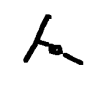

Angle error:  47


In [ ]:
one_single_image = False

if one_single_image:
    img = cv2.imread('/content/test_block/block_test2.JPG', cv2.IMREAD_GRAYSCALE)
    original_img = img
    rotated_img, rotation = augment(original_img)
    rotated_img_new = rotated_img[None, ]
    predicted_rotation = model.predict(rotated_img_new)
    print('True angle: ', rotation, 'Predicted angle: ', np.argmax(predicted_rotation))
    cv2_imshow(rotated_img)
    print('Angle error: ', angle_error(rotation, np.argmax(predicted_rotation)))

1/1 [==============================] - 0s 39ms/step
Predicted angle:  85


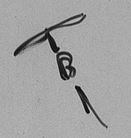

In [ ]:
one_single_image = False

if one_single_image:
    img = cv2.imread('/content/test_block/block_test1.JPG', cv2.IMREAD_GRAYSCALE)
    dim = (75, 75)
    re_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    image_shape = re_img.reshape(1, 75, 75)
    model.load_weights('/content/block_rotation_model_2.h5')
    predicted = model.predict(image_shape)
    print('Predicted angle: ', np.argmax(predicted))
    cv2_imshow(img)